Idea:

Hacer Gaussian Process y Partial Pooling

Vamos a arrancar modelando como evoluciona el precio de un jugador cuando envejece. Para esto usaremos solo 2 parametros de nuestros datos:
- Edad del jugador
- Precio del jugador

Usaremos el Gaussian Process porque parece ser una distr que estima bien el comportamiento esperado.

Usaremos Partial Pooling para agrupar jugadores parecidos entre ellos (ver si conviene por continente, por liga, division, etc)

Vamos a agarrar un grupo de jugadores y generar el Gaussian Process entre ellos. Y asi con todos los conjuntos de grupos qu tengamos.


Link al dataset: https://www.kaggle.com/datasets/davidcariboo/player-scores/data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from scipy.stats import expon, norm   # Medidas de desempeño
import pymc as pm

In [2]:
# Chequear que este en el Drive de los dos integrantes del grupo
file_path_dir = '../sandbox/football/kaggle/'
file_path_appearances = file_path_dir + 'appearances.csv'
file_path_players = file_path_dir + 'players.csv'
file_path_games = file_path_dir + 'games.csv'
file_path_player_valuations = file_path_dir + 'player_valuations.csv'

try:
  appearances = pd.read_csv(file_path_appearances)
  players = pd.read_csv(file_path_players)
  games = pd.read_csv(file_path_games)
  valuations = pd.read_csv(file_path_player_valuations)
  print("CSV loaded successfully.")
except FileNotFoundError:
  print("File not found at the specified path.")
except Exception as e:
  print("An error occurred while loading the CSV:", e)

CSV loaded successfully.


## Armar el dataset

Como modelo base vamos a querer obtener:
- jugador
- edad
- precio 

In [3]:
player_ids_names = players[["player_id", "name"]]
player_valuations_data = valuations[["player_id", "market_value_in_eur", "date"]]
players_with_age = players[["player_id", "name", "date_of_birth"]]

# drop any rows with missing values
player_ids_names = player_ids_names.dropna()
player_valuations_data = player_valuations_data.dropna()
players_with_age = players_with_age.dropna()

# reset the index of the DataFrames
player_ids_names = player_ids_names.reset_index(drop=True)
player_valuations_data = player_valuations_data.reset_index(drop=True)
players_with_age = players_with_age.reset_index(drop=True)

In [4]:
from datetime import datetime

#Transforma date a años (saco los meses y dias porque no nos preocupa tanto la exactitud)
def calculate_age(date_of_birth):
    if isinstance(date_of_birth, str):
        current_date = datetime(2024, 11, 4)    # Ultima fecha de nuestro dataset.
        birth_date = datetime.strptime(date_of_birth, "%Y-%m-%d")

        age = current_date.year - birth_date.year
        if (current_date.month, current_date.day) < (birth_date.month, birth_date.day):
            age -= 1

        return age
    else:
        return None

players_with_age = players_with_age.dropna(subset=["date_of_birth"])  # Eliminamos los jugadores sin fecha de nacimiento
players_with_age['age'] = players_with_age['date_of_birth'].apply(calculate_age)    # Calculamos la edad
players_with_age.drop("date_of_birth", axis = 1)    # Eliminamos "date_of_birth"

,player_id,name,age
0,10,Miroslav Klose,46
1,26,Roman Weidenfeller,44
2,65,Dimitar Berbatov,43
3,77,Lúcio,46
4,80,Tom Starke,43
...,...,...,...
31521,1264305,Sjors-Lowis Hermsen,18
31522,1266282,Yaroslav Shevchenko,18
31523,1268326,Tymur Butenko,17
31524,1268378,Adnan Efe Durmuşoğlu,18


In [5]:
from datetime import datetime

#Transforma date a años (saco los meses y dias porque no nos preocupa tanto la exactitud)
def calculate_age(date_of_birth):
    if isinstance(date_of_birth, str):
        current_date = datetime(2024, 11, 4)    # Ultima fecha de nuestro dataset.
        birth_date = datetime.strptime(date_of_birth, "%Y-%m-%d")

        age = current_date.year - birth_date.year
        if (current_date.month, current_date.day) < (birth_date.month, birth_date.day):
            age -= 1

        return age
    else:
        return None

players_with_age['age'] = players_with_age['date_of_birth'].apply(calculate_age)    # Calculamos la edad
players_with_age = players_with_age.drop("date_of_birth", axis = 1)    # Eliminamos "date_of_birth"

Convierto date_of_birth a age

In [6]:
merged_df = players_with_age.merge(player_valuations_data, on='player_id').merge(player_ids_names, on='player_id')
merged_df

,player_id,name_x,age,market_value_in_eur,date,name_y
0,10,Miroslav Klose,46,7000000,2004-10-04,Miroslav Klose
1,10,Miroslav Klose,46,9000000,2005-01-07,Miroslav Klose
2,10,Miroslav Klose,46,12000000,2005-05-05,Miroslav Klose
3,10,Miroslav Klose,46,15000000,2005-09-30,Miroslav Klose
4,10,Miroslav Klose,46,20000000,2006-01-09,Miroslav Klose
...,...,...,...,...,...,...
477626,1230202,Borja Vázquez,19,50000,2024-06-24,Borja Vázquez
477627,1237999,Samuel Obinaya,19,100000,2024-06-06,Samuel Obinaya
477628,1240467,Artem Prysyazhnyuk,19,50000,2024-06-06,Artem Prysyazhnyuk
477629,1240762,Araphat Mohammed,18,50000,2024-06-10,Araphat Mohammed


In [9]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor

# Comparamos la edad con el valor de mercado de los jugadores
X = merged_df[['age']].values  # Features (e.g., age)
y = merged_df['market_value_in_eur'].values  # Target (e.g., market value)

# Usamos un subset de los datos para entrenar el modelo y que no se sature la memoria
subset_size = 5000  # Ajustar este valor según la memoria disponible 
indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X[indices]
y_subset = y[indices]

# Crear un Proceso Gaussiano
gp = GaussianProcessRegressor(kernel=None, n_restarts_optimizer=10)

# Fitear
gp.fit(X_subset, y_subset)

# Hacer predicciones (por ejemplo, para edades entre 20 y 40 años)
X_pred = np.arange(18, 41).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)



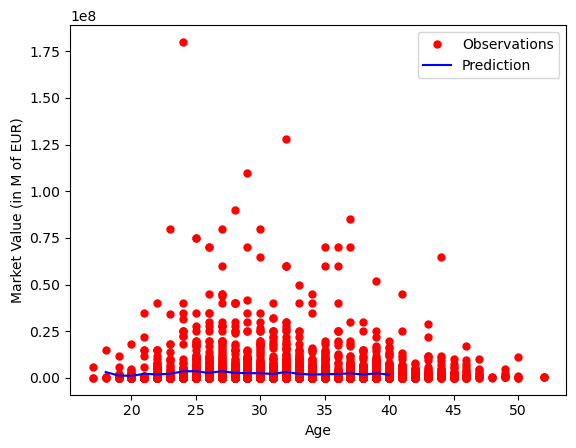

In [10]:
# Plotting the results
import matplotlib.pyplot as plt

plt.figure()
plt.plot(X_subset, y_subset, 'r.', markersize=10, label='Observations')
plt.plot(X_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='k')
plt.xlabel('Age')
plt.ylabel('Market Value (in M of EUR)')
plt.legend()
plt.show()